In [5]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from scipy.stats import norm
import matplotlib.pyplot as plt
from tqdm.auto import tqdm

In [6]:
df = pd.read_csv('https://stepik.org/media/attachments/lesson/396008/hw_bootstrap.csv', sep = ';')
df.head()

,Unnamed: 0,value,experimentVariant
0,1,"10,3804953740268",Control
1,2,"9,54686666784264",Control
2,3,"11,0882146509904",Control
3,4,"10,1472740570122",Control
4,5,"9,78980767524929",Control


In [7]:
df.drop(columns = 'Unnamed: 0', inplace = True)
df.head()

,value,experimentVariant
0,"10,3804953740268",Control
1,"9,54686666784264",Control
2,"11,0882146509904",Control
3,"10,1472740570122",Control
4,"9,78980767524929",Control


In [8]:
df.experimentVariant.value_counts()

Control      500
Treatment    500
Name: experimentVariant, dtype: int64

In [9]:
df.dtypes

value                object
experimentVariant    object
dtype: object

In [1]:
df.value = df.value.str.replace(pat = ',', repl = '.') 
# заменяется decimal = ',' в pd.read_csv

NameError: name 'df' is not defined

In [11]:
df.head()

,value,experimentVariant
0,10.3804953740268,Control
1,9.54686666784264,Control
2,11.0882146509904,Control
3,10.1472740570122,Control
4,9.78980767524929,Control


In [12]:
df.value = df.value.astype('float')

In [13]:
df.dtypes

value                float64
experimentVariant     object
dtype: object

In [14]:
x = df.query('experimentVariant == "Control"')['value'].reset_index()
x.drop(columns = 'index', inplace = True)
x

,value
0,10.380495
1,9.546867
2,11.088215
3,10.147274
4,9.789808
...,...
495,10.973929
496,10.261074
497,8.780090
498,11.169078


In [15]:
y = df.query('experimentVariant == "Treatment"')['value'].reset_index()
y.drop(columns = 'index', inplace = True)
y

,value
0,10.380495
1,9.546867
2,11.088215
3,10.147274
4,9.789808
...,...
495,1000.000000
496,1200.000000
497,1500.000000
498,2000.000000


In [16]:
df = x.join(y, lsuffix='_control', rsuffix='_treatment', how = 'outer')
df.tail(20)

,value_control,value_treatment
480,8.783989,8.783989
481,9.123822,9.123822
482,10.173804,10.173804
483,8.593694,8.593694
484,11.889777,11.889777
485,11.114726,11.114726
486,9.970658,9.970658
487,10.651236,10.651236
488,8.937850,8.937850
489,9.314387,9.314387


In [17]:
df = pd.DataFrame(df)
df.head()

,value_control,value_treatment
0,10.380495,10.380495
1,9.546867,9.546867
2,11.088215,11.088215
3,10.147274,10.147274
4,9.789808,9.789808


# Bootsrap (np.mean) vs Mann–Whitney

## Bootstrap (np.mean)

In [38]:
def get_bootstrap_mean(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.mean, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
                                ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
                                ).values
        boot_data.append(statistic(samples_1-samples_2)) # mean() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)   
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
                    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
                    )
    p_value = min(p_1, p_2) * 2
    
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
    
    return {"boot_data": boot_data, 
            "quants": quants, 
            "p_value": p_value}

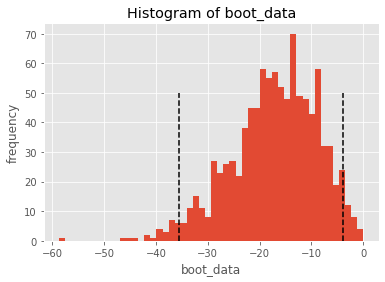

In [39]:
booted_data = get_bootstrap_mean(df.value_control, df.value_treatment) # в результате хранится разница двух распределений, ДИ и pvalue

In [24]:
booted_data["p_value"]

0.040904913927942155

In [25]:
ss.mannwhitneyu(df.value_control, df.value_treatment)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

### Вывод 1
Нулевая гипотеза формулируется как: распределение признака в первой выборке соответствует распределению признака во второй выборке.
Критерий Манна-Уитни не позволяет отвергнуть нулевую гипотезу о равенстве средних. Полагаю, это вызвано тем, что ранги != реальным значениям, а выборки отличаются между собой только последними 5-ю элементами, что в понятиях рангов глобально не влияет.
В то же время, бутстрэп по среднему позволяет отклонить нулевую гипотезу, поскольку 0 в доверительный интервал не входит, т.к. последние 5 значений внесли весомый вклад в эту разницу.

# Bootsrap (np.median) vs Mann–Whitney 

## Bootstrap (np.median)

In [26]:
def get_bootstrap_med(
    data_column_1, # числовые значения первой выборки
    data_column_2, # числовые значения второй выборки
    boot_it = 1000, # количество бутстрэп-подвыборок
    statistic = np.median, # интересующая нас статистика
    bootstrap_conf_level = 0.95 # уровень значимости
):
    boot_len = max([len(data_column_1), len(data_column_2)])
    boot_data = []
    for i in tqdm(range(boot_it)): # извлекаем подвыборки
        samples_1 = data_column_1.sample(
            boot_len, 
            replace = True # параметр возвращения
        ).values
        
        samples_2 = data_column_2.sample(
            boot_len, 
            replace = True
        ).values
        
        boot_data.append(statistic(samples_1-samples_2)) # median() - применяем статистику
        
    pd_boot_data = pd.DataFrame(boot_data)
        
    left_quant = (1 - bootstrap_conf_level)/2
    right_quant = 1 - (1 - bootstrap_conf_level) / 2
    quants = pd_boot_data.quantile([left_quant, right_quant])
        
    p_1 = norm.cdf(
        x = 0, 
        loc = np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_2 = norm.cdf(
        x = 0, 
        loc = -np.mean(boot_data), 
        scale = np.std(boot_data)
    )
    p_value = min(p_1, p_2) * 2
       
    # Визуализация
    plt.hist(pd_boot_data[0], bins = 50)
    
    plt.style.use('ggplot')
    plt.vlines(quants,ymin=0,ymax=50,linestyle='--')
    plt.xlabel('boot_data')
    plt.ylabel('frequency')
    plt.title("Histogram of boot_data")
    plt.show()
       
    return {"boot_data": boot_data, 
            "quants": quants,
            "p_value": p_value}

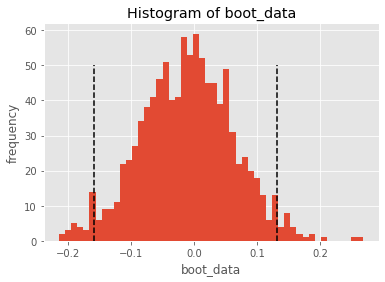

In [27]:
booted_data_med = get_bootstrap_med(df.value_control, df.value_treatment) # в результате хранится разница двух распределений, ДИ и pvalue

In [28]:
booted_data_med["p_value"]

0.8854781331964487

In [29]:
ss.mannwhitneyu(df.value_control, df.value_treatment)

MannwhitneyuResult(statistic=124189.5, pvalue=0.42960742912427896)

### Вывод 2
Нулевая гипотеза формулируется как: распределение признака в первой выборке соответствует распределению признака во второй выборке.
Критерий Манна-Уитни не позволяет отвергнуть нулевую гипотезу о равенстве средних. Полагаю, это вызвано тем, что ранги != реальным значениям, а выборки отличаются между собой только последними 5-ю элементами, что в понятиях рангов глобально не влияет.
Бутстрэп по медиане не позволяет отклонить нулевую гипотезу, поскольку 0 в доверительный интервал входит, а p-значение близка к 1. 